# Hoax Detection Using Traditional Machine Learning
## Dataset from Satria Data 2020 - Big Data Challenge

## RNN with LSTM Layer

In [1]:
# import dependencies
import re
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from string import punctuation
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.optimizers import Adam, SGD
from keras.backend import clear_session
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, Dropout, LSTM
from pandarallel import pandarallel

%matplotlib inline

# multiprocessing Initialization
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
# Read Dataset
train_data = pd.read_excel("../data/training/DataLatih.xlsx", engine="openpyxl")
test_data = pd.read_excel("../data/testing/DataUji.xlsx", engine="openpyxl")

## Pre-processing

In [3]:
# Reconstruct train dataframe
train_df = pd.DataFrame()
train_df["konten"] = train_data["judul_translate"] + " " + train_data["narasi_translate"]
train_df["Class"] = train_data["label"]

# Reconstruct test dataframe
test_df = pd.DataFrame()
test_df["ID"] = test_data["ID"]
test_df["konten"] = test_data["judul_translate"] + " " + test_data["narasi_translate"]

In [4]:
# define stopword list, indonesia
STOPWORDS = set(StopWordRemoverFactory().get_stop_words() + stopwords.words('english'))

# define list kata singkat
KATASINGKAT = {"dlm":"dalam", "gw":"saya", "yg":"yang", "lu":"kamu", "dkt":"dekat", "kalo":"kalau", "n":"and"}

# define stemmer sastrawi for Indonesia
stemmer_ind = StemmerFactory().create_stemmer()
stemmer_eng = PorterStemmer()

In [5]:
# function of preprocessing
def remove_kata_singkat(word):
    if word in list(KATASINGKAT.keys()):
        return KATASINGKAT.get(word)
    else:
        return word
    
def normalize_word(row):
    # remove punctuation
    konten = re.sub(r'[^a-zA-Z\s]', ' ', row.konten, re.I|re.A)
    
    # case folding and remove kata singkat
    konten = " ".join([remove_kata_singkat(word.lower()).strip() for word in nltk.word_tokenize(konten)])
    
    # remove stopword and number
    konten = " ".join([word for word in nltk.word_tokenize(konten) if word not in punctuation and word.isalpha() and word not in STOPWORDS])
    
    # stemming
    konten = stemmer_ind.stem(konten)
    konten = stemmer_eng.stem(konten)
    
    # final assignment
    row.konten = konten
    
    return row

In [ ]:
# Parallel preprocess to dataframe with progressbar
train_df = train_df.parallel_apply(normalize_word, axis=1)
test_df = test_df.parallel_apply(normalize_word, axis=1)

In [ ]:
konten_train = train_df["konten"]
konten_test = test_df["konten"]

In [ ]:
konten_train.shape, konten_test.shape

In [216]:
# TOKENIZE BEFORE BUILD FEATURE
num_words = 1000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(konten_train.values)

X = tokenizer.texts_to_sequences(konten_train.values)
y = train_df["Class"]
X_test = tokenizer.texts_to_sequences(konten_test.values)

In [217]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

In [218]:
maxlen = 200
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [236]:
y_train[y_train.values == 0]

1714    0
83      0
2129    0
3005    0
2578    0
       ..
3649    0
2547    0
4078    0
2061    0
421     0
Name: Class, Length: 613, dtype: int64

## Build and Train Model

In [220]:
import keras
keras.backend.clear_session()

In [221]:
# hyperparameter
EPOCHS = 10
BS = 20
LEARNING_RATE = 0.001

In [222]:
# Build our simple LSTM model
embed_dim = 32
lstm_out = 49

model = Sequential()
model.add(Embedding(num_words, embed_dim, input_length = X_train.shape[1]))
model.add(LSTM(lstm_out))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           32000     
_________________________________________________________________
lstm (LSTM)                  (None, 49)                16072     
_________________________________________________________________
dense (Dense)                (None, 1)                 50        
Total params: 48,122
Trainable params: 48,122
Non-trainable params: 0
_________________________________________________________________


In [223]:
# COMPILE MODEL
adam = Adam(learning_rate=LEARNING_RATE)
model.compile(loss = 'binary_crossentropy', optimizer="adam", metrics = ['accuracy'])

In [224]:
# instantiate model callbacks
model_callbacks = [
        # EarlyStopping(monitor="val_loss", patience=5),
        CSVLogger(
            filename=f"../log/history_recurrent_lstm.csv", separator=",", append=False),
        ModelCheckpoint(
            filepath=f"../model/model_recurrent_lstm_val_loss.h5", monitor="val_loss", save_best_only=True),
        ModelCheckpoint(
            filepath=f"../model/model_recurrent_lstm_val_acc.h5", monitor="val_accuracy", save_best_only=True)
    ]

In [225]:
# TRAIN MODEL
history = model.fit(
    X_train, y_train.values, 
    validation_data=(X_val, y_val.values), 
    epochs=EPOCHS, 
    batch_size=BS,
    callbacks=model_callbacks,
)

Epoch 1/10
170/170 [==============================] - 32s 64ms/step - loss: 0.5266 - accuracy: 0.7871 - val_loss: 0.4725 - val_accuracy: 0.8194
Epoch 2/10
170/170 [==============================] - 9s 50ms/step - loss: 0.4778 - accuracy: 0.8166 - val_loss: 0.4749 - val_accuracy: 0.8194
Epoch 3/10
170/170 [==============================] - 8s 46ms/step - loss: 0.4553 - accuracy: 0.8309 - val_loss: 0.4738 - val_accuracy: 0.8194
Epoch 4/10
170/170 [==============================] - 9s 53ms/step - loss: 0.4635 - accuracy: 0.8271 - val_loss: 0.4726 - val_accuracy: 0.8194
Epoch 5/10
170/170 [==============================] - 9s 54ms/step - loss: 0.4648 - accuracy: 0.8248 - val_loss: 0.4752 - val_accuracy: 0.8194
Epoch 6/10
170/170 [==============================] - 10s 57ms/step - loss: 0.4835 - accuracy: 0.8122 - val_loss: 0.4733 - val_accuracy: 0.8194
Epoch 7/10
170/170 [==============================] - 9s 54ms/step - loss: 0.5059 - accuracy: 0.7988 - val_loss: 0.4734 - val_accuracy: 0.81

In [ ]:
batch_size = 32
model.fit(X_train, Y_train, epochs=8, batch_size=batch_size, validation_split=0.2, callbacks=[ckpt_callback])

In [ ]:
Y = pd.get_dummies(df_train['Class']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=Y)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

In [ ]:
model = load_model('keras_model')

In [ ]:
probas = model.predict(X_test)

In [ ]:
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(1, 10))
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(classes[np.argmax(Y_test, axis=1)], probas)))
print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(Y_test, axis=1)], preds)))
skplt.plot_confusion_matrix(classes[np.argmax(Y_test, axis=1)], preds)

## Evaluate Model

In [241]:
# load saved model
model = load_model(f"../model/model_recurrent_lstm_val_acc.h5")

In [242]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy\t: {:.4f}".format(accuracy))
print("Training Loss\t\t: {:.4f}".format(loss))

val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=False)
print("\nValidation Accuracy\t: {:.4f}".format(val_accuracy))
print("Validation Loss\t\t: {:.4f}".format(val_loss))

Training Accuracy	: 0.8189
Training Loss		: 0.4733

Validation Accuracy	: 0.8194
Validation Loss		: 0.4725


In [243]:
y_pred = (model.predict(X_val))

In [244]:
np.round(y_pred)

array([[0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.82551765],
       [0.825

In [230]:
# Classification Report
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.18      1.00      0.31       153
           1       0.00      0.00      0.00       694

    accuracy                           0.18       847
   macro avg       0.09      0.50      0.15       847
weighted avg       0.03      0.18      0.06       847



/home/prinanda/anaconda3/envs/text/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/prinanda/anaconda3/envs/text/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/prinanda/anaconda3/envs/text/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

<AxesSubplot:>

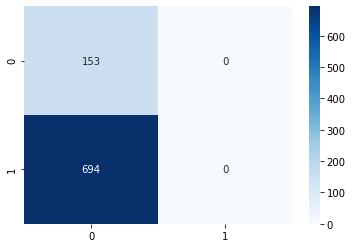

In [231]:
# Confusion matrix
cf_matrix = confusion_matrix(y_val, y_pred, labels=[0,1])
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt='2')

## Visualization

In [232]:
# Font option
title_font = {'weight': 'medium', 'size': 'medium'}
axis_font = {'size': 'small'}

Numero = [x for x in range(EPOCHS)]

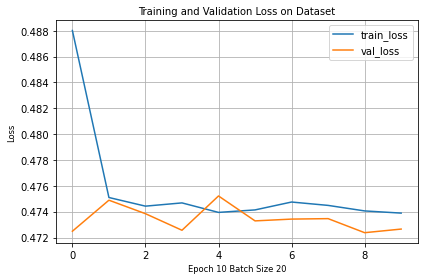

In [233]:
# Plot loss
plt.figure()
plt.plot(Numero, history.history["loss"], label="train_loss")
plt.plot(Numero, history.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss on Dataset", **title_font)
plt.xlabel(f"Epoch {EPOCHS} Batch Size {BS}", **axis_font)
plt.ylabel("Loss", **axis_font)
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid()

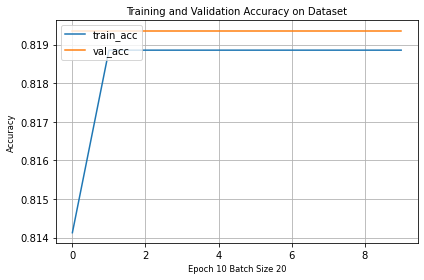

In [234]:
# plot accuracy
plt.figure()
plt.plot(Numero, history.history["accuracy"], label="train_acc")
plt.plot(Numero, history.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy on Dataset", **title_font)
plt.xlabel(
    f"Epoch {EPOCHS} Batch Size {BS}", **axis_font)
plt.ylabel("Accuracy", **axis_font)
plt.legend(loc='upper left')
plt.tight_layout()
plt.grid()

## Save Results to CSV

In [235]:
predictions_lstm = [int(y[0]) for y in np.round(model.predict(X_test))]
results_lstm = pd.DataFrame(zip(test_df["ID"], predictions_lstm), columns=["ID", "Prediksi"])
results_lstm.to_csv("../result/neural_network/result_recurrent_lstm.csv", index=False)